## Apartments Price Prediction in Belgium: historical sales and geographical data

In [1]:
# import created modules
from source.data_cleaning import DataCleaning as dtcln
from source.data_cleaning import describe_with_tukey_fences
import source.modeling as modeling
import source.evaluation as evaluation

# import standard libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats

#import scikit modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

from tabulate import tabulate
#below two packages are for feature selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

REAL_ESTATE_CSV_FILEPATH = os.path.join(os.getcwd(), 'data', 'clean_dataset.csv')
REAL_ESTATE_SB_CSV_FILEPATH = os.path.join(os.getcwd(), 'assets', 'outputs', 'df_with_statbel.csv')
CLEANED_CSV_FILEPATH = os.path.join(os.getcwd(), 'assets', 'outputs', 'df_after_cleaning.csv')

#['source','land_surface', 'facades_number', 'swimming_pool_has','postcode_median_price',
#              'property_subtype_median_facades_number', 'building_state_agg_median_price']
NUM_CV_FOLDS = 3
DEGREE_MAX = 3

## Data preprocessing: cleaning and conversion from text to numerical

In [2]:
cleaner = dtcln(csv_filepath=REAL_ESTATE_SB_CSV_FILEPATH,
                property_subtype = "APARTMENT_BLOCK")
df, df_outliers = cleaner.get_cleaned_dataframe(cleaned_csv_path=CLEANED_CSV_FILEPATH)
#excluding text columns as requested (boolean kept)
df = df.select_dtypes(exclude=['object'])

Initial dataset, shape: (423, 22)
Aggregated parameters replacing categorical ones, shape: (423, 22)
0 Dropped duplicates, shape: (423, 22)


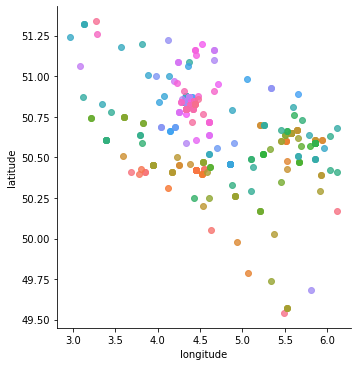

In [3]:
#geographical distribution and median price by postcode

g = sns.lmplot(x='longitude', y='latitude', data=df,
           fit_reg=False, # No regression line
           hue='price_m_by_postcode')
g._legend.remove()

In [4]:
#show results of outliers detection and removal
df_outliers

,column,method,type,count,%,first_outlier,index
0,price,fence_tukey_max,max,29,6.86,1549000.0,"[5, 11, 22, 34, 44, 54, 78, 93, 95, 105, 107, ..."
1,rooms_number,fence_tukey_max,max,21,4.96,14.0,"[34, 51, 102, 122, 128, 139, 167, 188, 204, 25..."
2,area,fence_tukey_max,max,24,5.67,716.0,"[22, 34, 93, 95, 102, 107, 114, 128, 167, 173,..."


In [5]:
#show no null values and no text types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 422
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   source                423 non-null    int64  
 1   postcode              423 non-null    int64  
 2   house_is              423 non-null    bool   
 3   price                 423 non-null    float64
 4   rooms_number          423 non-null    float64
 5   area                  423 non-null    float64
 6   equipped_kitchen_has  423 non-null    bool   
 7   furnished             423 non-null    bool   
 8   open_fire             423 non-null    bool   
 9   terrace               423 non-null    bool   
 10  terrace_area          423 non-null    float64
 11  garden                423 non-null    bool   
 12  garden_area           423 non-null    float64
 13  land_surface          423 non-null    float64
 14  swimming_pool_has     423 non-null    bool   
 15  price_m_by_postcode   4

In [6]:
#show statistical information to consider further processing
describe_with_tukey_fences(df)

,source,postcode,price,rooms_number,area,terrace_area,garden_area,land_surface,price_m_by_postcode,latitude,longitude,facades_number
count,423.0,423.000000,4.230000e+02,423.000000,423.000000,423.000000,423.000000,423.000000,423.00000,423.000000,423.000000,423.0
mean,6.0,3700.465721,6.816875e+05,6.070922,363.295508,8.950355,50.643026,440.456265,193490.38974,50.685437,4.692742,0.0
std,0.0,2501.346234,7.583838e+05,6.502619,432.899182,22.961433,320.364392,1826.158572,72726.41137,0.253876,0.690712,0.0
min,6.0,1000.000000,8.200000e+04,0.000000,42.000000,0.000000,0.000000,0.000000,37530.49000,49.540000,2.970000,0.0
5%,6.0,1000.000000,1.500000e+05,0.000000,112.300000,0.000000,0.000000,0.000000,112172.39000,50.290000,3.600000,0.0
6%,6.0,1030.000000,1.550000e+05,0.000000,130.640000,0.000000,0.000000,0.000000,115354.67000,50.362800,3.783200,0.0
25%,6.0,1080.000000,2.795000e+05,3.000000,200.000000,0.000000,0.000000,45.000000,133959.98000,50.580000,4.320000,0.0
50%,6.0,4000.000000,4.500000e+05,5.000000,270.000000,0.000000,0.000000,147.000000,178005.38000,50.710000,4.420000,0.0
75%,6.0,5300.000000,7.850000e+05,7.000000,400.000000,5.000000,0.000000,307.000000,220024.56000,50.850000,5.460000,0.0
94%,6.0,7850.000000,1.641560e+06,12.000000,694.560000,44.680000,137.680000,1308.920000,317314.62000,50.966800,5.860000,0.0


## Features selection

In [7]:
#Drop features which are not relevent
#FM facades improve you could have a look at it
df = df.drop(['source','land_surface', 'swimming_pool_has'],axis=1)
#calculating price per metre square to detect outliers
df['price_per_sqmtr'] = df['price'] / df['area']

In [8]:
#postcode_stats contains the no. of properties in each postcode
postcode_stats = df['postcode'].value_counts(ascending=False)

Any location having less than 10 data points should be tagged as "9999" location.
This way number of categories can be reduced by huge amount.
Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [9]:
postcode_value_less_than_10 = postcode_stats[postcode_stats<=10]
postcode_value_less_than_10
df['postcode'] = df['postcode'].apply(lambda x: '9999' if x in postcode_value_less_than_10 else x)

In [10]:
#FM I would not remove outliers by SD since distribution does not seem normal to me
''' Outlier Removal Using Standard Deviation and Mean '''
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('postcode'):
        m =np.mean(subdf.price_per_sqmtr)
        sd = np.std(subdf.price_per_sqmtr)
        reduced_df = subdf[(subdf.price_per_sqmtr > (m - (2 * sd))) & (subdf.price_per_sqmtr <= (m +(2 * sd))) ]
        df_out = pd.concat([df_out,reduced_df],ignore_index= True)
    return df_out
#Applying the function on our dataframe
df = remove_pps_outliers(df)
#Now, we can drop price per metre square column as our outlier detection is done '''
df = df.drop(['price_per_sqmtr'],axis='columns')

In [11]:
''' To check correlation of features using chisquare method
It gives us the list of featues which are relevant and which are not relevant for the model '''
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None

        self.dfObserved = None
        self.dfExpected = None

    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        #print(result)

    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)

        self.dfObserved = pd.crosstab(Y,X)
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof

        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)

        self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
testColumns = ['postcode', 'house_is', 'rooms_number', #'property_subtype'
       'area', 'equipped_kitchen_has', 'furnished', 'open_fire', 'terrace',
       'garden'] #, 'building_state_agg'] #'region',
for var in testColumns:
    cT.TestIndependence(colX=var,colY="price" )

#Drop the features which are irrelevant as per chi-square '''
df = df.drop(['furnished','garden'],axis = 1) #'property_subtype'

In [12]:
#Use One Hot Encoding For postcodes
dummies = pd.get_dummies(df,prefix= '',prefix_sep = '')
#df = dummies.drop(['9999','to_renovate','B',],axis='columns') #FM add postcode if needed

In [13]:
X = df.drop(['price'],axis='columns')
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

## Machine Learning Model

In [14]:
#Returns a linear regression model fitted with Ordinary Least Squares method
lin_reg = modeling.OLS_linear_regression(X_train, y_train)
#Plots learning curves (R² Score) based on training data and k-folds cross-validation
modeling.plot_OLS_lin_reg_r2_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS)
#Plots learning curves (Mean Squared Error) based on training data and k-folds cross-validation
modeling.plot_OLS_lin_reg_MSE_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS)

LinAlgError: SVD did not converge in Linear Least Squares

In [ ]:
modeling.plot_poly_reg_validation_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS, degree_max=DEGREE_MAX)

## Model evaluation

#### Correlation

In [ ]:
plt.figure(figsize=(10,5))
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn')

In [ ]:
def predict_price(model, prop_type, postcode, area, rooms, garden, terrace, prop_condition):
    """
    Function predicts the price with random input data.


    :param prop_type: property type data
    :param postcode: postcode data
    :param area: area
    :param rooms: number of rooms
    :param garden: garden
    :param terrace: terrace
    :param prop_condition: proeprty condition
    :return: price value
    """
    loc_index = np.where(X.columns == postcode)[0]
    prop_condition_index = np.where(X.columns == prop_condition)[0]
    x = np.zeros(len(X.columns))
    x[0] = prop_type
    x[1] = rooms
    x[2] = area
    x[3] = terrace
    x[4] = garden

    if loc_index >= 0:
        x[loc_index] = 1

    if prop_condition_index >= 0:
        x[prop_condition_index] = 1
    
    return model.predict([x])[0]

In [ ]:
#lin_reg contains our previously created model
model_evaluation_obj = evaluation.Model_Evaluation(lin_reg)
ytrain_predictions, ytest_predictions = model_evaluation_obj.get_predictions(X_train, X_test)
model_evaluation_obj.predict_model(X_train, y_train, X_test, y_test)

In [ ]:
predicted_price = predict_price(lin_reg, 1, 8300, 100 , 3, 1, 0,'good')
print(predicted_price)